In [11]:
import warnings, optuna
warnings.filterwarnings("ignore", category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [5]:
import os
import pandas as pd
import numpy as np

RANDOM_STATE = 42
candidate_paths = [
    "./data/train_clean.csv",
    "data/train_clean.csv",
    "./train_clean.csv",
    "/content/data/train_clean.csv",
    "../data/train_clean.csv",
    "/mnt/data/train_clean.csv"
]
train_path = next((p for p in candidate_paths if os.path.exists(p)), None)
if train_path is None:
    raise FileNotFoundError(f"No se encontró 'train_clean.csv' en las rutas: {candidate_paths}")
train = pd.read_csv(train_path)
print(f"Dataset cargado: {train.shape}  ->  {train_path}")


Dataset cargado: (7030723, 16)  ->  ../data/train_clean.csv


In [6]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score

RANDOM_STATE = 42
df = train[train['label'].isin([0,1])].copy()
if 'merchant_freq' not in df.columns:
    merchant_counts = df['merchant_id'].value_counts()
    df['merchant_freq'] = df['merchant_id'].map(merchant_counts).fillna(0).astype(int)

FEATURES = [
    'activity_len','actions_0','actions_2','actions_3',
    'unique_items','unique_categories','unique_brands',
    'day_span','has_1111','age_range','gender','merchant_freq'
]

missing = [f for f in FEATURES if f not in df.columns]
if missing:
    raise ValueError(f"Faltan features en el dataset: {missing}")

X = df[FEATURES].copy()
y = df['label'].astype(int)

for c in ['age_range','gender','merchant_id']:
    if c in X.columns:
        X[c] = X[c].fillna('MISSING').astype('category')

X[['activity_len','actions_0','actions_2','actions_3','unique_items','unique_categories','unique_brands','day_span','has_1111','merchant_freq']] = \
    X[['activity_len','actions_0','actions_2','actions_3','unique_items','unique_categories','unique_brands','day_span','has_1111','merchant_freq']].fillna(0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight_global = neg / pos if pos > 0 else 1.0

print("X_train shape:", X_train.shape, "X_val shape:", X_val.shape)
print("Train class counts -> neg:", int(neg), "pos:", int(pos), "scale_pos_weight:", round(scale_pos_weight_global,4))

def apply_sampling(X_tr, y_tr, method):
    if method == 'smote_under':
        sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=5, sampling_strategy=0.5)
        X_s, y_s = sm.fit_resample(X_tr, y_tr)
        ru = RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy=0.7)
        X_res, y_res = ru.fit_resample(X_s, y_s)
        return X_res, y_res, None
    if method == 'scale_pos_weight':
        neg_local = (y_tr == 0).sum()
        pos_local = (y_tr == 1).sum()
        spw = neg_local / pos_local if pos_local > 0 else 1.0
        return X_tr, y_tr, spw
    return X_tr, y_tr, None


X_train shape: (208691, 12) X_val shape: (52173, 12)
Train class counts -> neg: 195929 pos: 12762 scale_pos_weight: 15.3525


In [7]:
print("Shapes ->", X_train.shape, X_val.shape)
print("\nTrain label counts:\n", y_train.value_counts())
print("\nProporción (pos/neg):", round((y_train==1).sum()/max(1,(y_train==0).sum()),6))
print("\nTipos de columnas:\n", X_train.dtypes)
print("\nNulls por columna:\n", X_train.isnull().sum())
display(X_train.head(5))
if 'merchant_freq' in X_train.columns:
    print("\nmerchant_freq stats:\n", X_train['merchant_freq'].describe())
    print("\nTop 10 merchant_freq values:\n", X_train['merchant_freq'].value_counts().head(10))
print("\nUnique values age_range:", X_train['age_range'].nunique() if 'age_range' in X_train.columns else None)
print("Unique values gender:", X_train['gender'].nunique() if 'gender' in X_train.columns else None)


Shapes -> (208691, 12) (52173, 12)

Train label counts:
 label
0    195929
1     12762
Name: count, dtype: int64

Proporción (pos/neg): 0.065136

Tipos de columnas:
 activity_len            int64
actions_0               int64
actions_2               int64
actions_3               int64
unique_items            int64
unique_categories       int64
unique_brands           int64
day_span                int64
has_1111                int64
age_range            category
gender               category
merchant_freq           int64
dtype: object

Nulls por columna:
 activity_len         0
actions_0            0
actions_2            0
actions_3            0
unique_items         0
unique_categories    0
unique_brands        0
day_span             0
has_1111             0
age_range            0
gender               0
merchant_freq        0
dtype: int64


,activity_len,actions_0,actions_2,actions_3,unique_items,unique_categories,unique_brands,day_span,has_1111,age_range,gender,merchant_freq
826182,10,9,1,0,5,1,1,0,1,0,0,1189
4302473,4,3,1,0,2,1,1,0,1,4,1,355
3877695,9,8,1,0,4,1,1,0,1,3,1,534
2874238,7,6,1,0,2,1,1,1,1,0,0,44
1013326,10,9,1,0,4,3,1,1,1,3,0,2542



merchant_freq stats:
 count    208691.000000
mean        574.052336
std         683.668915
min           1.000000
25%         108.000000
50%         329.000000
75%         763.000000
max        3379.000000
Name: merchant_freq, dtype: float64

Top 10 merchant_freq values:
 merchant_freq
3379    2751
3254    2612
2542    2042
2483    2029
1231    1944
1925    1548
881     1416
1636    1325
1626    1294
1578    1252
Name: count, dtype: int64

Unique values age_range: 9
Unique values gender: 3


In [9]:
from sklearn.preprocessing import OrdinalEncoder

cat_cols = X.select_dtypes(['category']).columns.tolist()
if len(cat_cols) > 0:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    oe.fit(X[cat_cols])
    X_cat_encoded = oe.transform(X[cat_cols])
    X_encoded = X.copy()
    X_encoded[cat_cols] = X_cat_encoded.astype(int)
else:
    X_encoded = X.copy()

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

cat_cols = [c for c in cat_cols if c in X_train.columns]
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

print("Codificación aplicada. Categóricas codificadas:", cat_cols)
print("X_train shape:", X_train.shape, "X_val shape:", X_val.shape)
print("Tipos después de codificar:\n", X_train.dtypes)


Codificación aplicada. Categóricas codificadas: ['age_range', 'gender']
X_train shape: (208691, 12) X_val shape: (52173, 12)
Tipos después de codificar:
 activity_len         int64
actions_0            int64
actions_2            int64
actions_3            int64
unique_items         int64
unique_categories    int64
unique_brands        int64
day_span             int64
has_1111             int64
age_range            int64
gender               int64
merchant_freq        int64
dtype: object


In [12]:
import numpy as np
import lightgbm as lgb
import optuna
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from sklearn.utils import shuffle

RANDOM_STATE = int(RANDOM_STATE)

def focal_obj(preds, dtrain, alpha=0.25, gamma=2.0):
    labels = dtrain.get_label()
    preds_sig = 1.0 / (1.0 + np.exp(-preds))
    eps = 1e-9
    p = np.clip(preds_sig, eps, 1.0-eps)
    y = labels
    p_t = p * y + (1 - p) * (1 - y)
    alpha_factor = alpha * y + (1 - alpha) * (1 - y)
    grad = alpha_factor * ( - (1 - p_t)**gamma ) * (y - p) + alpha_factor * ( - gamma * (1 - p_t)**(gamma - 1) * ( - (y - p) ) * np.log(p_t + eps) )
    hess = np.clip(np.abs(grad) * 0.5 + 1e-6, 1e-12, 1e6)
    return grad, hess

cat_idx_local = cat_idx if 'cat_idx' in globals() else []

def apply_sampling_local(X_tr, y_tr, method):
    if method == 'smote_under':
        sm = SMOTENC(categorical_features=cat_idx_local, random_state=RANDOM_STATE, sampling_strategy=0.5)
        X_s, y_s = sm.fit_resample(X_tr.values, y_tr.values)
        ru = RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy=0.7)
        X_res, y_res = ru.fit_resample(X_s, y_s)
        X_res, y_res = shuffle(X_res, y_res, random_state=RANDOM_STATE)
        return X_res, y_res, None
    if method == 'scale_pos_weight':
        neg_local = int((y_tr == 0).sum())
        pos_local = int((y_tr == 1).sum())
        spw = neg_local / pos_local if pos_local > 0 else 1.0
        return X_tr.values, y_tr.values, spw
    return X_tr.values, y_tr.values, None

def optuna_objective(trial):
    balance_method = trial.suggest_categorical('balance_method', ['scale_pos_weight', 'smote_under', 'none'])
    use_focal = trial.suggest_categorical('use_focal', [False, False, True])
    params = {
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': 'gbdt',
        'num_threads': 4,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 512, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'verbose': -1
    }
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    for tr_idx, va_idx in skf.split(X_train, y_train):
        X_tr = X_train.iloc[tr_idx]
        y_tr = y_train.iloc[tr_idx]
        X_va = X_train.iloc[va_idx]
        y_va = y_train.iloc[va_idx]
        X_tr_res, y_tr_res, spw = apply_sampling_local(X_tr, y_tr, balance_method)
        if balance_method == 'scale_pos_weight' and spw is not None:
            params['scale_pos_weight'] = spw
        else:
            params.pop('scale_pos_weight', None)
        try:
            dtrain = lgb.Dataset(X_tr_res, label=y_tr_res, categorical_feature=cat_idx_local if len(cat_idx_local)>0 else 'auto')
            dval = lgb.Dataset(X_va.values, label=y_va.values, reference=dtrain)
            if use_focal:
                bst = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=[dval], callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)], fobj=lambda preds, dtrain: focal_obj(preds, dtrain, alpha=trial.suggest_float('focal_alpha', 0.01, 0.5), gamma=trial.suggest_float('focal_gamma', 0.5, 3.0)))
            else:
                bst = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=[dval], callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)])
            y_va_proba = bst.predict(X_va.values, num_iteration=bst.best_iteration)
            score = float(average_precision_score(y_va.values, y_va_proba))
            scores.append(score)
        except Exception as e:
            return 0.0
    return float(np.mean(scores))

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(optuna_objective, n_trials=20, show_progress_bar=True)
print("Best value:", study.best_value)
print("Best params:")
for k,v in study.best_params.items():
    print(k, ":", v)
study.trials_dataframe().to_csv('./optuna_lgb_study.csv', index=False)
print("Study saved to ./optuna_lgb_study.csv")


  0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[286]	valid_0's average_precision: 0.0878898
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[683]	valid_0's average_precision: 0.0927706
Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.089949:   5%|▌         | 1/20 [00:46<14:47, 46.72s/it]

Early stopping, best iteration is:
[95]	valid_0's average_precision: 0.0891865
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[452]	valid_0's average_precision: 0.120786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's average_precision: 0.11745
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[590]	valid_0's average_precision: 0.126551


Best trial: 1. Best value: 0.121596:  10%|█         | 2/20 [00:58<07:54, 26.37s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[303]	valid_0's average_precision: 0.0968233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	valid_0's average_precision: 0.10365
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's average_precision: 0.0976039


Best trial: 1. Best value: 0.121596:  20%|██        | 4/20 [01:35<05:39, 21.19s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's average_precision: 0.0951066
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's average_precision: 0.100436
Training until validation scores don't improve for 50 rounds


Best trial: 1. Best value: 0.121596:  25%|██▌       | 5/20 [02:03<05:51, 23.46s/it]

Early stopping, best iteration is:
[46]	valid_0's average_precision: 0.09619
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's average_precision: 0.11774
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's average_precision: 0.117158
Training until validation scores don't improve for 50 rounds


Best trial: 1. Best value: 0.121596:  30%|███       | 6/20 [02:10<04:18, 18.49s/it]

Early stopping, best iteration is:
[103]	valid_0's average_precision: 0.120019
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's average_precision: 0.116728
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[445]	valid_0's average_precision: 0.112748
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[875]	valid_0's average_precision: 0.121106


Best trial: 1. Best value: 0.121596:  35%|███▌      | 7/20 [03:06<06:28, 29.86s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's average_precision: 0.098344
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's average_precision: 0.103394
Training until validation scores don't improve for 50 rounds


Best trial: 1. Best value: 0.121596:  40%|████      | 8/20 [03:31<05:39, 28.27s/it]

Early stopping, best iteration is:
[20]	valid_0's average_precision: 0.100617
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's average_precision: 0.117575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's average_precision: 0.114257
Training until validation scores don't improve for 50 rounds


Best trial: 1. Best value: 0.121596:  45%|████▌     | 9/20 [03:35<03:52, 21.15s/it]

Early stopping, best iteration is:
[39]	valid_0's average_precision: 0.119859
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's average_precision: 0.092905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's average_precision: 0.0976804
Training until validation scores don't improve for 50 rounds


Best trial: 1. Best value: 0.121596:  50%|█████     | 10/20 [04:02<03:47, 22.75s/it]

Early stopping, best iteration is:
[49]	valid_0's average_precision: 0.0949044
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's average_precision: 0.118328
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[576]	valid_0's average_precision: 0.115702
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's average_precision: 0.121775


Best trial: 1. Best value: 0.121596:  55%|█████▌    | 11/20 [04:30<03:39, 24.34s/it]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's average_precision: 0.118083
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's average_precision: 0.116849
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's average_precision: 0.121485


Best trial: 1. Best value: 0.121596:  60%|██████    | 12/20 [05:03<03:35, 26.99s/it]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's average_precision: 0.117844
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[921]	valid_0's average_precision: 0.116598
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's average_precision: 0.123125


Best trial: 1. Best value: 0.121596:  65%|██████▌   | 13/20 [05:34<03:16, 28.09s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[580]	valid_0's average_precision: 0.121697
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[465]	valid_0's average_precision: 0.117513
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[584]	valid_0's average_precision: 0.127818


Best trial: 13. Best value: 0.122342:  70%|███████   | 14/20 [05:55<02:36, 26.01s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's average_precision: 0.120071
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[285]	valid_0's average_precision: 0.116053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[444]	valid_0's average_precision: 0.127222


Best trial: 13. Best value: 0.122342:  75%|███████▌  | 15/20 [06:09<01:51, 22.35s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's average_precision: 0.119934
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's average_precision: 0.114973
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[187]	valid_0's average_precision: 0.124289


Best trial: 13. Best value: 0.122342:  80%|████████  | 16/20 [06:18<01:14, 18.55s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's average_precision: 0.111408
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's average_precision: 0.114677
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[656]	valid_0's average_precision: 0.119343


Best trial: 13. Best value: 0.122342:  85%|████████▌ | 17/20 [06:43<01:01, 20.38s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[377]	valid_0's average_precision: 0.116454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's average_precision: 0.109524
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[633]	valid_0's average_precision: 0.121445


Best trial: 13. Best value: 0.122342:  90%|█████████ | 18/20 [06:58<00:37, 18.80s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[228]	valid_0's average_precision: 0.121845
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's average_precision: 0.118181
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's average_precision: 0.12796


Best trial: 18. Best value: 0.122662:  95%|█████████▌| 19/20 [07:09<00:16, 16.42s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's average_precision: 0.120574
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's average_precision: 0.116998
Training until validation scores don't improve for 50 rounds


Best trial: 18. Best value: 0.122662: 100%|██████████| 20/20 [07:16<00:00, 13.64s/it]

Early stopping, best iteration is:
[202]	valid_0's average_precision: 0.125662


Best trial: 18. Best value: 0.122662: 100%|██████████| 20/20 [07:16<00:00, 21.84s/it]

Best value: 0.12266197319124482
Best params:
balance_method : none
use_focal : False
learning_rate : 0.04560531460469594
num_leaves : 31
max_depth : 11
min_child_samples : 130
subsample : 0.6975928550046506
colsample_bytree : 0.5225097918162374
reg_alpha : 3.359183778987816e-07
reg_lambda : 0.0020972217499319926
Study saved to ./optuna_lgb_study.csv


In [13]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_recall_curve
from sklearn.utils import shuffle
import joblib

# -----------------------
# Config / paths
# -----------------------
os.makedirs('./saved_models/lightgbm/', exist_ok=True)
RANDOM_STATE = int(RANDOM_STATE) if 'RANDOM_STATE' in globals() else 42

# -----------------------
# Helper: umbral óptimo
# -----------------------
def find_optimal_threshold(y_true, y_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    best_f1 = -1.0
    best_t = 0.5
    for i in range(len(thresholds)):
        t = thresholds[i]
        p = precisions[i]
        r = recalls[i]
        if (p + r) == 0:
            f1 = 0.0
        else:
            f1 = 2 * p * r / (p + r)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

# -----------------------
# Recuperar mejores params del study
# -----------------------
if 'study' not in globals():
    raise RuntimeError("No se encontró 'study' en el namespace. Ejecuta primero la búsqueda de Optuna.")

best = study.best_params.copy()
balance_method = best.pop('balance_method', 'none')
use_focal = best.pop('use_focal', False)

# Convertir a parámetros LightGBM compatibles
lgb_params = {
    'objective': 'binary',
    'metric': 'average_precision',
    'boosting_type': 'gbdt',
    'learning_rate': float(best.get('learning_rate', 0.05)),
    'num_leaves': int(best.get('num_leaves', 31)),
    'max_depth': int(best.get('max_depth', 11)),
    'min_child_samples': int(best.get('min_child_samples', 20)),
    'subsample': float(best.get('subsample', 1.0)),
    'colsample_bytree': float(best.get('colsample_bytree', 1.0)),
    'reg_alpha': float(best.get('reg_alpha', 0.0)),
    'reg_lambda': float(best.get('reg_lambda', 0.0)),
    'verbose': -1,
    'num_threads': min(4, os.cpu_count() or 1)
}

print("Balance method:", balance_method)
print("Use focal (won't be used unless True):", use_focal)
print("LightGBM params:", {k: lgb_params[k] for k in ['learning_rate','num_leaves','max_depth','min_child_samples']})

# -----------------------
# Definir columnas categóricas
# -----------------------
cat_features = []
for c in ['age_range', 'gender']:
    if c in X_train.columns:

        X_train[c] = X_train[c].astype('category')
        X_val[c] = X_val[c].astype('category')
        cat_features.append(c)

print("Categorical features used:", cat_features)

# -----------------------
# Aplicar balanceo
# -----------------------
if balance_method == 'smote_under':
    # SMOTENC necesita índices de columnas categóricas si pasamos arrays
    cat_idx = [X_train.columns.get_loc(c) for c in cat_features] if cat_features else []
    sm = SMOTENC(categorical_features=cat_idx, random_state=RANDOM_STATE, sampling_strategy=0.5)
    X_res, y_res = sm.fit_resample(X_train.values, y_train.values)
    ru = RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy=0.7)
    X_res2, y_res2 = ru.fit_resample(X_res, y_res)
    X_train_final = pd.DataFrame(X_res2, columns=X_train.columns)
    # reconvertir categorías
    for c in cat_features:
        X_train_final[c] = X_train_final[c].astype('category')
    y_train_final = pd.Series(y_res2)
    print("Después SMOTE+Under: X_train_final shape:", X_train_final.shape)
elif balance_method == 'scale_pos_weight':
    # calculo scale_pos_weight sobre train real
    neg = int((y_train==0).sum())
    pos = int((y_train==1).sum())
    spw = neg / pos if pos > 0 else 1.0
    lgb_params['scale_pos_weight'] = spw
    X_train_final = X_train.copy()
    y_train_final = y_train.copy()
    print("Usando scale_pos_weight:", round(spw,4))
else:  # 'none' o desconocido
    X_train_final = X_train.copy()
    y_train_final = y_train.copy()
    print("No se aplica resample. Usando X_train original.")

# -----------------------
# Construir Dataset y entrenar
# -----------------------
dtrain = lgb.Dataset(X_train_final, label=y_train_final, categorical_feature=cat_features if cat_features else 'auto')
dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)


def focal_obj(preds, dtrain_local, alpha=0.25, gamma=2.0):
    labels = dtrain_local.get_label()
    preds_sig = 1.0 / (1.0 + np.exp(-preds))
    p = np.clip(preds_sig, 1e-9, 1-1e-9)
    y = labels
    p_t = p * y + (1 - p) * (1 - y)
    alpha_factor = alpha * y + (1 - alpha) * (1 - y)
    grad = alpha_factor * ( - (1 - p_t)**gamma ) * (y - p) + alpha_factor * ( - gamma * (1 - p_t)**(gamma - 1) * ( - (y - p) ) * np.log(p_t + 1e-9) )
    hess = np.clip(np.abs(grad) * 0.5 + 1e-6, 1e-12, 1e6)
    return grad, hess

print("Entrenando modelo final... (early stopping 50 rounds)")
if use_focal:
    bst = lgb.train(lgb_params, dtrain, num_boost_round=2000, valid_sets=[dval],
                    fobj=lambda preds, dtrain_local: focal_obj(preds, dtrain_local, alpha=0.25, gamma=2.0),
                    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)])
else:
    bst = lgb.train(lgb_params, dtrain, num_boost_round=2000, valid_sets=[dval],
                    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)])

# -----------------------
# Predicción y métricas
# -----------------------
y_val_proba = bst.predict(X_val, num_iteration=bst.best_iteration)
y_val_pred_default = (y_val_proba >= 0.5).astype(int)

pr_auc = average_precision_score(y_val, y_val_proba)
roc_auc = roc_auc_score(y_val, y_val_proba)
f1_def = f1_score(y_val, y_val_pred_default)

print(f"\nResultados en X_val (best_iteration={bst.best_iteration}):")
print("PR-AUC (Average Precision):", round(pr_auc,6))
print("ROC-AUC:", round(roc_auc,6))
print("F1 (threshold 0.5):", round(f1_def,6))

# -----------------------
# Umbral óptimo por F1
# -----------------------
opt_t, opt_f1 = find_optimal_threshold(y_val.values, y_val_proba)
y_val_pred_opt = (y_val_proba >= opt_t).astype(int)
f1_opt = f1_score(y_val, y_val_pred_opt)

print(f"\nUmbral óptimo (PR-curve) -> threshold: {opt_t:.5f}, F1: {opt_f1:.6f} (recomputado F1: {f1_opt:.6f})")

# -----------------------
# Guardar modelo y resultados
# -----------------------
model_path = './saved_models/lightgbm/best_lgb_model.txt'
bst.save_model(model_path)
# guardar metadata y params
meta = {
    'best_params': study.best_params,
    'best_value': study.best_value,
    'pr_auc_val': pr_auc,
    'roc_auc_val': roc_auc,
    'f1_default': f1_def,
    'f1_optimal': f1_opt,
    'optimal_threshold': float(opt_t)
}
pd.Series(meta).to_json('./saved_models/lightgbm/best_lgb_metadata.json')

print("\nModelo guardado en:", model_path)
print("Metadata guardada en: ./saved_models/lightgbm/best_lgb_metadata.json")

# También guarda el booster con joblib
try:
    joblib.dump(bst, './saved_models/lightgbm/bst_joblib.pkl')
    print("Booster guardado con joblib: ./saved_models/lightgbm/bst_joblib.pkl")
except Exception:
    pass

# -----------------------
# feature importance (top 30)
# -----------------------
try:
    fi = bst.feature_importance(importance_type='gain')
    fn = bst.feature_name()
    fi_df = pd.DataFrame({'feature': fn, 'importance': fi}).sort_values('importance', ascending=False).head(30)
    fi_df.to_csv('./saved_models/lightgbm/feature_importance.csv', index=False)
    print("Feature importances guardadas: ./saved_models/lightgbm/feature_importance.csv")
except Exception:
    pass


Balance method: none
Use focal (won't be used unless True): False
LightGBM params: {'learning_rate': 0.04560531460469594, 'num_leaves': 31, 'max_depth': 11, 'min_child_samples': 130}
Categorical features used: ['age_range', 'gender']
No se aplica resample. Usando X_train original.
Entrenando modelo final... (early stopping 50 rounds)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	valid_0's average_precision: 0.126701

Resultados en X_val (best_iteration=150):
PR-AUC (Average Precision): 0.126701
ROC-AUC: 0.655869
F1 (threshold 0.5): 0.0

Umbral óptimo (PR-curve) -> threshold: 0.09545, F1: 0.189713 (recomputado F1: 0.189713)

Modelo guardado en: ./saved_models/lightgbm/best_lgb_model.txt
Metadata guardada en: ./saved_models/lightgbm/best_lgb_metadata.json
Booster guardado con joblib: ./saved_models/lightgbm/bst_joblib.pkl
Feature importances guardadas: ./saved_models/lightgbm/feature_importance.csv


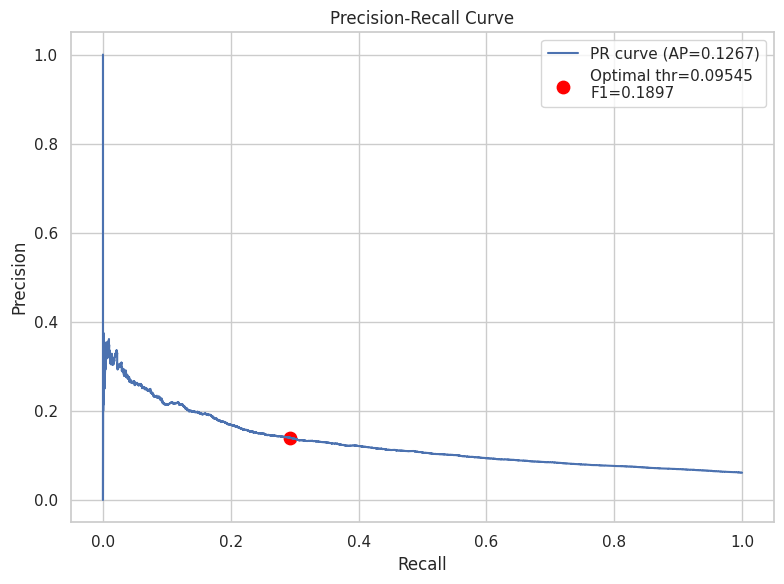

PR curve saved -> ./saved_models/lightgbm/plots/pr_curve.png


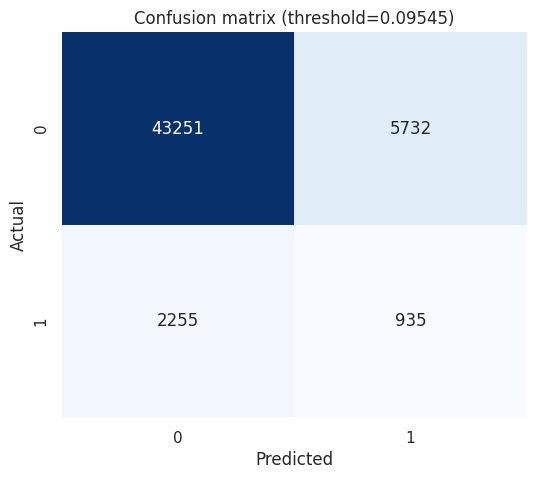

Confusion matrix (counts) saved -> ./saved_models/lightgbm/plots/confusion_matrix_counts.png


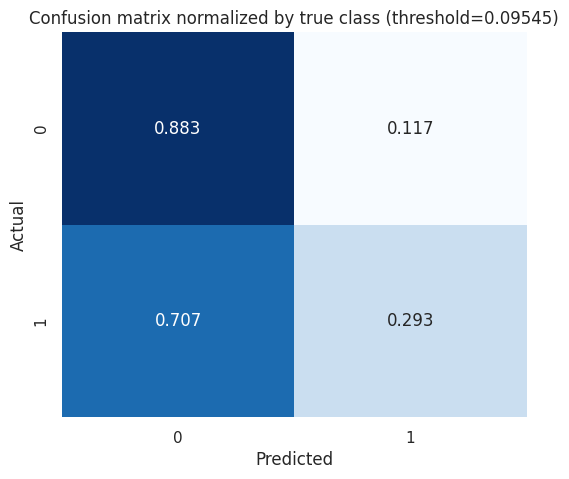

Confusion matrix (normalized) saved -> ./saved_models/lightgbm/plots/confusion_matrix_norm.png

Classification report (threshold = 0.09545):

              precision    recall  f1-score   support

           0     0.9504    0.8830    0.9155     48983
           1     0.1402    0.2931    0.1897      3190

    accuracy                         0.8469     52173
   macro avg     0.5453    0.5880    0.5526     52173
weighted avg     0.9009    0.8469    0.8711     52173


Resumen métricas: PR-AUC=0.126701, ROC-AUC=0.655869, F1(0.5)=0.000000, F1(opt)=0.189713
Top feature importances saved -> ./saved_models/lightgbm/feature_importance_top20.csv


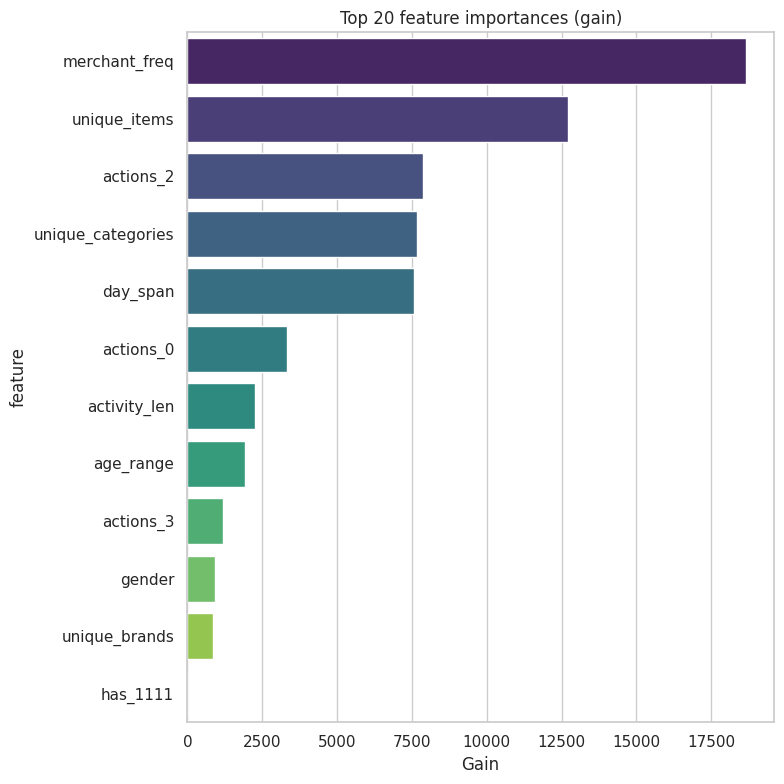

Feature importance plot saved -> ./saved_models/lightgbm/plots/feature_importance_top20.png
Summary saved -> ./saved_models/lightgbm/plots/metrics_summary.json


In [14]:
# Celda: Plot PR curve, confusion matrix (umbral óptimo), classification report y feature importances
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, confusion_matrix, classification_report

sns.set(style="whitegrid")
os.makedirs('./saved_models/lightgbm/plots/', exist_ok=True)

# Variables asumidas en memoria: bst, X_val, y_val, y_val_proba, opt_t
# Si no existen exactamente esos nombres, ajusta: y_val_proba = bst.predict(X_val, num_iteration=bst.best_iteration)

if 'y_val_proba' not in globals():
    y_val_proba = bst.predict(X_val, num_iteration=bst.best_iteration)

# --- PR curve and optimal threshold mark
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
pr_auc_val = average_precision_score(y_val, y_val_proba)
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label=f'PR curve (AP={pr_auc_val:.4f})')
# Find closest threshold index (thresholds length == len(precisions)-1)
if 'opt_t' in globals():
    idx = np.argmin(np.abs(thresholds - opt_t)) if thresholds.size>0 else None
    if idx is not None and idx < len(recalls):
        plt.scatter(recalls[idx], precisions[idx], color='red', s=80,
                    label=f'Optimal thr={opt_t:.5f}\nF1={(2*precisions[idx]*recalls[idx]/(precisions[idx]+recalls[idx]) if (precisions[idx]+recalls[idx])>0 else 0):.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
pr_path = './saved_models/lightgbm/plots/pr_curve.png'
plt.savefig(pr_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'PR curve saved -> {pr_path}')

# --- Confusion matrix at optimal threshold
threshold = opt_t if 'opt_t' in globals() else 0.5
y_pred_opt = (y_val_proba >= threshold).astype(int)
cm = confusion_matrix(y_val, y_pred_opt)
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion matrix (threshold={threshold:.5f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_path = './saved_models/lightgbm/plots/confusion_matrix_counts.png'
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Confusion matrix (counts) saved -> {cm_path}')

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues', cbar=False)
plt.title(f'Confusion matrix normalized by true class (threshold={threshold:.5f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
cmn_path = './saved_models/lightgbm/plots/confusion_matrix_norm.png'
plt.savefig(cmn_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Confusion matrix (normalized) saved -> {cmn_path}')

# --- Classification report
print("\nClassification report (threshold = {:.5f}):\n".format(threshold))
print(classification_report(y_val, y_pred_opt, digits=4))

# --- Metrics summary
roc = roc_auc_score(y_val, y_val_proba)
pr = pr_auc_val
f1_default = 0.0
try:
    # compute F1 at default 0.5
    y_pred_def = (y_val_proba >= 0.5).astype(int)
    from sklearn.metrics import f1_score
    f1_default = f1_score(y_val, y_pred_def)
except Exception:
    pass
f1_opt = f1_score(y_val, y_pred_opt)
print(f"\nResumen métricas: PR-AUC={pr:.6f}, ROC-AUC={roc:.6f}, F1(0.5)={f1_default:.6f}, F1(opt)={f1_opt:.6f}")

# --- Feature importances (top 20)
try:
    fi_gain = bst.feature_importance(importance_type='gain')
    fi_split = bst.feature_importance(importance_type='split')
    fnames = bst.feature_name()
    fi_df = pd.DataFrame({'feature': fnames, 'gain': fi_gain, 'split': fi_split})
    fi_df = fi_df.sort_values('gain', ascending=False).reset_index(drop=True)
    fi_csv = './saved_models/lightgbm/feature_importance_top20.csv'
    fi_df.head(20).to_csv(fi_csv, index=False)
    print(f'Top feature importances saved -> {fi_csv}')

    # plot
    plt.figure(figsize=(8,8))
    sns.barplot(x='gain', y='feature', data=fi_df.head(20), palette='viridis')
    plt.title('Top 20 feature importances (gain)')
    plt.xlabel('Gain')
    plt.tight_layout()
    fi_png = './saved_models/lightgbm/plots/feature_importance_top20.png'
    plt.savefig(fi_png, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Feature importance plot saved -> {fi_png}')
except Exception as e:
    print("No se pudo obtener feature importances desde bst:", e)

# --- Guardar tabla resumen de métricas simples
summary = {
    'pr_auc_val': float(pr),
    'roc_auc_val': float(roc),
    'f1_at_0.5': float(f1_default),
    'f1_at_opt_threshold': float(f1_opt),
    'optimal_threshold': float(threshold),
    'best_iteration': int(bst.best_iteration)
}
pd.Series(summary).to_json('./saved_models/lightgbm/plots/metrics_summary.json')
print("Summary saved -> ./saved_models/lightgbm/plots/metrics_summary.json")


El modelo muestra capacidad discriminativa limitada: PR-AUC (Average Precision) = 0.1267 y ROC-AUC = 0.6559, lo que indica señal pero baja precisión en la clase positiva. Al ajustar el umbral a 0.09545 se obtiene F1 = 0.1897 (precision ≈ 0.14, recall ≈ 0.29), con una matriz de confusión en validación de 43251 TN, 5732 FP, 2255 FN y 935 TP, y una accuracy global de 0.8469. La curva Precision-Recall cae rápidamente conforme aumenta el recall, reflejando el trade-off entre recuperar más positivos y perder precisión. En importancias de features aparecen primero merchant_freq, unique_items, actions_2, unique_categories y day_span; luego actions_0, activity_len, age_range, actions_3, gender, unique_brands y has_1111. En resumen: el modelo captura cierta señal útil y detecta algunos positivos al usar un umbral bajo, pero su precisión es baja, por lo que cualquier uso práctico debe considerar ese balance entre recall y tasas de falsas alarmas.

In [16]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

def find_optimal_threshold(y_true, y_proba):
    """
    Recorre la curva precision-recall y devuelve:
      - threshold que maximiza F1
      - best_f1 (float)
      - dict con precision/recall/thresholds (útil para plot)
    Nota: precision_recall_curve devuelve arrays donde len(thresholds) == len(precisions)-1
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    best_f1 = -1.0
    best_thr = 0.5

    # thresholds correspond to precisions[0:len(thresholds)] / recalls[0:len(thresholds)]
    for i, thr in enumerate(thresholds):
        p = precisions[i]
        r = recalls[i]
        if p + r == 0:
            cur_f1 = 0.0
        else:
            cur_f1 = 2 * (p * r) / (p + r)
        if cur_f1 > best_f1:
            best_f1 = cur_f1
            best_thr = thr

    # also compute F1 at default 0.5 in case thresholds misses it
    f1_at_05 = f1_score(y_true, (y_proba >= 0.5).astype(int))
    return {
        "best_threshold": float(best_thr),
        "best_f1": float(best_f1),
        "f1_at_0.5": float(f1_at_05),
        "precisions": precisions,
        "recalls": recalls,
        "thresholds": thresholds
    }


Umbral óptimo (F1): 0.09545009095848175
Best F1 (PR): 0.18971289438977376
F1 en 0.5: 0.0

Matriz de confusión (counts):
 [[43251  5732]
 [ 2255   935]]

Reporte clasificación (umbral = 0.09545):

              precision    recall  f1-score   support

           0     0.9504    0.8830    0.9155     48983
           1     0.1402    0.2931    0.1897      3190

    accuracy                         0.8469     52173
   macro avg     0.5453    0.5880    0.5526     52173
weighted avg     0.9009    0.8469    0.8711     52173



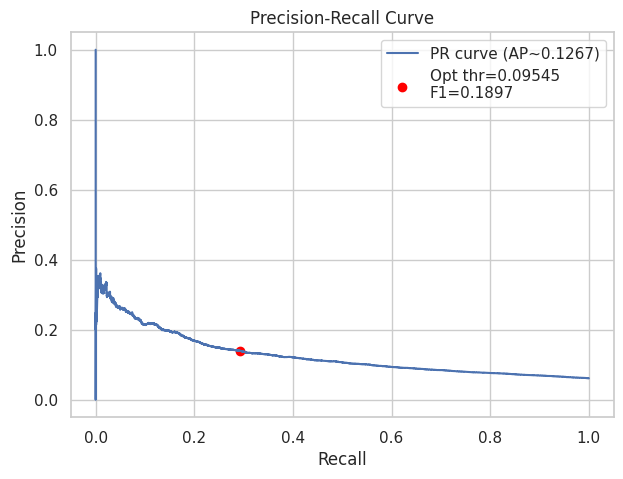

In [17]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

y_proba_val = bst.predict(X_val) 


res = find_optimal_threshold(y_val, y_proba_val)


print("Umbral óptimo (F1):", res["best_threshold"])
print("Best F1 (PR):", res["best_f1"])
print("F1 en 0.5:", res["f1_at_0.5"])


thr = res["best_threshold"]
y_pred_opt = (y_proba_val >= thr).astype(int)
cm = confusion_matrix(y_val, y_pred_opt)
print("\nMatriz de confusión (counts):\n", cm)
print("\nReporte clasificación (umbral = {:.5f}):\n".format(thr))
print(classification_report(y_val, y_pred_opt, digits=4))


precisions = res["precisions"]
recalls = res["recalls"]
thresholds = res["thresholds"]

plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, label=f'PR curve (AP~{average_precision_score(y_val, y_proba_val):.4f})')

if len(thresholds) > 0:
    idx = np.argmin(np.abs(thresholds - thr))
    plt.scatter(recalls[idx], precisions[idx], color='red', label=f'Opt thr={thr:.5f}\nF1={res["best_f1"]:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


La mejor configuración encontrada alcanza AP (PR-AUC) = 0.1267, F1 máximo en la PR-curve ≈ 0.1897 (umbral ≈ 0.09545).
Con ese umbral en el conjunto de validación la clase positiva muestra precision ≈ 0.14, recall ≈ 0.293. Eso significa que el modelo detecta ~29% de los positivos pero con baja precisión

In [20]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
import traceback

RANDOM_STATE = 42
N_FOLDS = 5

def optuna_objective_cv(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',            
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 512),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'seed': RANDOM_STATE,
        'force_row_wise': True
    }

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    aps = []

    try:
        for tr_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[val_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[val_idx]

            dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=['age_range','gender'])
            dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain, categorical_feature=['age_range','gender'])

            bst = lgb.train(
                params,
                dtrain,
                num_boost_round=500,   
                valid_sets=[dvalid],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50),
                    lgb.log_evaluation(period=0)  
                ]
            )

            y_va_proba = bst.predict(X_va)
            aps.append(average_precision_score(y_va, y_va_proba))

    except Exception as e:
        
        print("Error en trial:", e)
        traceback.print_exc()
        return float(-999.0)

    if len(aps) == 0:
        return float(-999.0)

    return float(np.mean(aps))


study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(optuna_objective_cv, n_trials=20, catch=(Exception,)) 


if len(study.trials) > 0:
    print("Completed trials:", len([t for t in study.trials if t.state.is_finished()]))
    print("Best AP (cv):", study.best_value)
    print("Best params:", study.best_params)
else:
    print("No trials recorded")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[397]	valid_0's auc: 0.658832
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[205]	valid_0's auc: 0.637816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[411]	valid_0's auc: 0.6567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's auc: 0.652869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's auc: 0.655832
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.654785
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's auc: 0.634688
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best

In [22]:
import os, json, joblib, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
import lightgbm as lgb

RANDOM_STATE = 42
os.makedirs('./saved_models/lightgbm', exist_ok=True)

if 'study' in globals() and getattr(study, 'best_params', None):
    bp = study.best_params.copy()
elif 'best_params' in globals():
    bp = best_params.copy()
else:
    raise RuntimeError("No best_params available. Ejecuta la optimización primero.")

bp.update({'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': RANDOM_STATE, 'force_row_wise': True})

if 'X_test' in globals() and 'y_test' in globals():
    X_train_full = X_train.copy()
    y_train_full = y_train.copy()
    X_test_use = X_test
    y_test_use = y_test
else:
    X_train_full, X_test_use, y_train_full, y_test_use = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE)

X_tr, X_val, y_tr, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, stratify=y_train_full, random_state=RANDOM_STATE)

categorical = ['age_range', 'gender'] if 'age_range' in X_tr.columns and 'gender' in X_tr.columns else None
dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical)
dvalid = lgb.Dataset(X_val, label=y_val, reference=dtrain, categorical_feature=categorical)

bst = lgb.train(bp, dtrain, num_boost_round=10000, valid_sets=[dvalid], callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=0)])

model_path = './saved_models/lightgbm/final_best_lgb_model.txt'
bst.save_model(model_path)
joblib.dump(bst, './saved_models/lightgbm/bst_joblib.pkl')

y_proba = bst.predict(X_test_use, num_iteration=bst.best_iteration or None)
ap = average_precision_score(y_test_use, y_proba)
roc = roc_auc_score(y_test_use, y_proba)
precision, recall, thresholds = precision_recall_curve(y_test_use, y_proba)
if thresholds.size > 0:
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
    best_idx = int(np.nanargmax(f1_scores))
    best_threshold = float(thresholds[best_idx])
    best_f1 = float(f1_scores[best_idx])
else:
    best_threshold = 0.5
    best_f1 = float(f1_score(y_test_use, (y_proba >= 0.5).astype(int)))

f1_05 = float(f1_score(y_test_use, (y_proba >= 0.5).astype(int)))
cm = confusion_matrix(y_test_use, (y_proba >= best_threshold).astype(int))

preds_df = X_test_use.copy()
preds_df['y_true'] = y_test_use.values
preds_df['y_proba'] = y_proba
preds_df['y_pred_opt'] = (y_proba >= best_threshold).astype(int)
preds_df.to_csv('./saved_models/lightgbm/test_predictions.csv', index=False)

metrics = {
    'AP': float(ap),
    'ROC_AUC': float(roc),
    'F1_0.5': float(f1_05),
    'F1_best': float(best_f1),
    'best_threshold': float(best_threshold),
    'best_iteration': int(bst.best_iteration)
}
with open('./saved_models/lightgbm/test_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("Entrenamiento y evaluación completados. Métricas:", metrics)
print("Modelo guardado en:", model_path)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.22173
Entrenamiento y evaluación completados. Métricas: {'AP': 0.12619633777392048, 'ROC_AUC': 0.6590038995627924, 'F1_0.5': 0.0, 'F1_best': 0.18974546340239487, 'best_threshold': 0.07884291494220971, 'best_iteration': 134}
Modelo guardado en: ./saved_models/lightgbm/final_best_lgb_model.txt


In [23]:
import os, json, joblib, numpy as np, lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix

RANDOM_STATE = 42
os.makedirs('./saved_models/lightgbm/scale_pos_weight', exist_ok=True)

if 'study' in globals() and getattr(study, 'best_params', None):
    params = study.best_params.copy()
elif 'best_params' in globals():
    params = best_params.copy()
else:
    raise RuntimeError("No best_params disponibles.")

params.update({'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': RANDOM_STATE, 'force_row_wise': True})

if 'X_test' in globals() and 'y_test' in globals():
    X_train_full = X_train.copy()
    y_train_full = y_train.copy()
    X_test_use = X_test
    y_test_use = y_test
else:
    X_train_full, X_test_use, y_train_full, y_test_use = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE)

pos = int(np.sum(y_train_full == 1))
neg = int(y_train_full.shape[0] - pos)
scale_pos_weight = float(neg / pos) if pos > 0 else 1.0
params['scale_pos_weight'] = scale_pos_weight

X_tr, X_val, y_tr, y_val = train_test_split(X_train_full, y_train_full, test_size=0.10, stratify=y_train_full, random_state=RANDOM_STATE)

categorical = ['age_range','gender'] if 'age_range' in X_tr.columns and 'gender' in X_tr.columns else None
dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical)
dvalid = lgb.Dataset(X_val, label=y_val, reference=dtrain, categorical_feature=categorical)

bst = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=[dvalid], callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=0)])

os.makedirs('./saved_models/lightgbm/scale_pos_weight', exist_ok=True)
bst.save_model('./saved_models/lightgbm/scale_pos_weight/model.txt')
joblib.dump(bst, './saved_models/lightgbm/scale_pos_weight/bst_joblib.pkl')

y_proba = bst.predict(X_test_use, num_iteration=bst.best_iteration or None)
ap = average_precision_score(y_test_use, y_proba)
roc = roc_auc_score(y_test_use, y_proba)
precision, recall, thresholds = precision_recall_curve(y_test_use, y_proba)
if thresholds.size>0:
    f1_scores = 2*(precision[:-1]*recall[:-1])/(precision[:-1]+recall[:-1]+1e-12)
    best_idx = int(np.nanargmax(f1_scores))
    best_threshold = float(thresholds[best_idx])
    best_f1 = float(f1_scores[best_idx])
else:
    best_threshold = 0.5
    best_f1 = float(f1_score(y_test_use, (y_proba>=0.5).astype(int)))

f1_05 = float(f1_score(y_test_use, (y_proba>=0.5).astype(int)))
cm = confusion_matrix(y_test_use, (y_proba>=best_threshold).astype(int))

preds_df = X_test_use.copy()
preds_df['y_true'] = y_test_use.values
preds_df['y_proba'] = y_proba
preds_df['y_pred_opt'] = (y_proba>=best_threshold).astype(int)
preds_df.to_csv('./saved_models/lightgbm/scale_pos_weight/test_predictions.csv', index=False)

metrics = {'AP': float(ap), 'ROC_AUC': float(roc), 'F1_0.5': float(f1_05), 'F1_best': float(best_f1), 'best_threshold': float(best_threshold), 'scale_pos_weight': scale_pos_weight, 'best_iteration': int(bst.best_iteration)}
with open('./saved_models/lightgbm/scale_pos_weight/test_metrics.json','w') as f:
    json.dump(metrics, f, indent=2)

print("Resultados scale_pos_weight:", metrics)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.273416
Resultados scale_pos_weight: {'AP': 0.09625871245772243, 'ROC_AUC': 0.6211538837590391, 'F1_0.5': 0.0, 'F1_best': 0.16452304394388448, 'best_threshold': 0.21306632879879847, 'scale_pos_weight': 15.352046460176991, 'best_iteration': 1}


In [24]:
import os, json, joblib, numpy as np, lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
try:
    from imblearn.under_sampling import RandomUnderSampler
except Exception as e:
    print("Imbalanced-learn no disponible:", e)
    raise

RANDOM_STATE = 42
os.makedirs('./saved_models/lightgbm/undersample', exist_ok=True)

if 'study' in globals() and getattr(study, 'best_params', None):
    params = study.best_params.copy()
elif 'best_params' in globals():
    params = best_params.copy()
else:
    raise RuntimeError("No best_params disponibles.")

params.update({'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': RANDOM_STATE, 'force_row_wise': True})

if 'X_test' in globals() and 'y_test' in globals():
    X_train_full = X_train.copy()
    y_train_full = y_train.copy()
    X_test_use = X_test
    y_test_use = y_test
else:
    X_train_full, X_test_use, y_train_full, y_test_use = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE)

rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_res, y_res = rus.fit_resample(X_train_full, y_train_full)

X_tr, X_val, y_tr, y_val = train_test_split(X_res, y_res, test_size=0.10, stratify=y_res, random_state=RANDOM_STATE)

categorical = ['age_range','gender'] if 'age_range' in X_tr.columns and 'gender' in X_tr.columns else None
dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical)
dvalid = lgb.Dataset(X_val, label=y_val, reference=dtrain, categorical_feature=categorical)

bst = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=[dvalid], callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=0)])

bst.save_model('./saved_models/lightgbm/undersample/model.txt')
joblib.dump(bst, './saved_models/lightgbm/undersample/bst_joblib.pkl')

y_proba = bst.predict(X_test_use, num_iteration=bst.best_iteration or None)
ap = average_precision_score(y_test_use, y_proba)
roc = roc_auc_score(y_test_use, y_proba)
precision, recall, thresholds = precision_recall_curve(y_test_use, y_proba)
if thresholds.size>0:
    f1_scores = 2*(precision[:-1]*recall[:-1])/(precision[:-1]+recall[:-1]+1e-12)
    best_idx = int(np.nanargmax(f1_scores))
    best_threshold = float(thresholds[best_idx])
    best_f1 = float(f1_scores[best_idx])
else:
    best_threshold = 0.5
    best_f1 = float(f1_score(y_test_use, (y_proba>=0.5).astype(int)))

f1_05 = float(f1_score(y_test_use, (y_proba>=0.5).astype(int)))
cm = confusion_matrix(y_test_use, (y_proba>=best_threshold).astype(int))

preds_df = X_test_use.copy()
preds_df['y_true'] = y_test_use.values
preds_df['y_proba'] = y_proba
preds_df['y_pred_opt'] = (y_proba>=best_threshold).astype(int)
preds_df.to_csv('./saved_models/lightgbm/undersample/test_predictions.csv', index=False)

metrics = {'AP': float(ap), 'ROC_AUC': float(roc), 'F1_0.5': float(f1_05), 'F1_best': float(best_f1), 'best_threshold': float(best_threshold), 'undersample_ratio': f"{X_res.shape[0]}/{X_train_full.shape[0]}", 'best_iteration': int(bst.best_iteration)}
with open('./saved_models/lightgbm/undersample/test_metrics.json','w') as f:
    json.dump(metrics, f, indent=2)

print("Resultados undersample:", metrics)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.657055
Resultados undersample: {'AP': 0.1146855031544976, 'ROC_AUC': 0.6455187470912384, 'F1_0.5': 0.16540650089640657, 'F1_best': 0.17843443670936396, 'best_threshold': 0.603164949799856, 'undersample_ratio': '21696/177387', 'best_iteration': 65}


In [25]:
import os, json, joblib, numpy as np, lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
os.makedirs('./saved_models/lightgbm/smote', exist_ok=True)

if 'study' in globals() and getattr(study, 'best_params', None):
    params = study.best_params.copy()
elif 'best_params' in globals():
    params = best_params.copy()
else:
    raise RuntimeError("No best_params disponibles.")

params.update({'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': RANDOM_STATE, 'force_row_wise': True})

if 'X_test' in globals() and 'y_test' in globals():
    X_train_full = X_train.copy()
    y_train_full = y_train.copy()
    X_test_use = X_test
    y_test_use = y_test
else:
    X_train_full, X_test_use, y_train_full, y_test_use = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE)

sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_train_full, y_train_full)

X_tr, X_val, y_tr, y_val = train_test_split(X_res, y_res, test_size=0.10, stratify=y_res, random_state=RANDOM_STATE)

categorical = ['age_range','gender'] if 'age_range' in X_tr.columns and 'gender' in X_tr.columns else None
dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical)
dvalid = lgb.Dataset(X_val, label=y_val, reference=dtrain, categorical_feature=categorical)

bst = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=[dvalid], callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=0)])

bst.save_model('./saved_models/lightgbm/smote/model.txt')
joblib.dump(bst, './saved_models/lightgbm/smote/bst_joblib.pkl')

y_proba = bst.predict(X_test_use, num_iteration=bst.best_iteration or None)
ap = average_precision_score(y_test_use, y_proba)
roc = roc_auc_score(y_test_use, y_proba)
precision, recall, thresholds = precision_recall_curve(y_test_use, y_proba)
if thresholds.size>0:
    f1_scores = 2*(precision[:-1]*recall[:-1])/(precision[:-1]+recall[:-1]+1e-12)
    best_idx = int(np.nanargmax(f1_scores))
    best_threshold = float(thresholds[best_idx])
    best_f1 = float(f1_scores[best_idx])
else:
    best_threshold = 0.5
    best_f1 = float(f1_score(y_test_use, (y_proba>=0.5).astype(int)))

f1_05 = float(f1_score(y_test_use, (y_proba>=0.5).astype(int)))
cm = confusion_matrix(y_test_use, (y_proba>=best_threshold).astype(int))

preds_df = X_test_use.copy()
preds_df['y_true'] = y_test_use.values
preds_df['y_proba'] = y_proba
preds_df['y_pred_opt'] = (y_proba>=best_threshold).astype(int)
preds_df.to_csv('./saved_models/lightgbm/smote/test_predictions.csv', index=False)

metrics = {'AP': float(ap), 'ROC_AUC': float(roc), 'F1_0.5': float(f1_05), 'F1_best': float(best_f1), 'best_threshold': float(best_threshold), 'resampled_size': f"{X_res.shape[0]}", 'best_iteration': int(bst.best_iteration)}
with open('./saved_models/lightgbm/smote/test_metrics.json','w') as f:
    json.dump(metrics, f, indent=2)

print("Resultados smote:", metrics)


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[9999]	valid_0's binary_logloss: 0.35194
Resultados smote: {'AP': 0.077689764361523, 'ROC_AUC': 0.5458365909686439, 'F1_0.5': 0.12073415543447089, 'F1_best': 0.12452543659805873, 'best_threshold': 0.3286769679308279, 'resampled_size': '333078', 'best_iteration': 9999}


SMOTE se aplicó para equilibrar la clase minoritaria, pero el rendimiento del modelo empeoró: la métrica PR-AUC (AP) descendió de ≈0.126 a 0.078 y la AUC-ROC también cayó notablemente. Esto sugiere que las muestras sintéticas generadas por SMOTE introdujeron ruido o una distribución irrelevante para el problema real que es un efecto común cuando existen variables categóricas o relaciones no lineales que SMOTE no modela correctamente. Además, el hecho de que el entrenamiento no haya cumplido early stopping (best_iteration muy alto) indica posible sobreajuste a los ejemplos sintéticos. 

In [27]:
import inspect
import os
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
import joblib

GAMMA = 2.0
ALPHA = 0.25
RANDOM_STATE = 42
N_FOLDS = 5
EARLY_STOP = 50
NUM_BOOST_ROUND = 500

def focal_objective(y_pred, dtrain):
    y = dtrain.get_label()
    p = 1.0 / (1.0 + np.exp(-y_pred))
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    weight_pos = ALPHA * ((1 - p) ** GAMMA)
    weight_neg = (1 - ALPHA) * (p ** GAMMA)
    weights = weight_pos * y + weight_neg * (1 - y)
    grad = (p - y) * weights
    hess = p * (1 - p) * weights
    return grad, hess

supports_fobj = 'fobj' in inspect.signature(lgb.train).parameters

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
aps = []
rocs = []
best_iters = []
fold = 0

for tr_idx, val_idx in skf.split(X_train, y_train):
    fold += 1
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    categorical = ['age_range','gender']
    if supports_fobj:
        dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical)
        dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain, categorical_feature=categorical)
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': -1,
            'min_child_samples': 20,
            'seed': RANDOM_STATE,
            'force_row_wise': True
        }
        bst = lgb.train(
            params,
            dtrain,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[dvalid],
            fobj=focal_objective,
            callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP), lgb.log_evaluation(period=0)]
        )
    else:
        sample_w = np.where(y_tr == 1, ALPHA, 1 - ALPHA)
        dtrain = lgb.Dataset(X_tr, label=y_tr, weight=sample_w, categorical_feature=categorical)
        dvalid = lgb.Dataset(X_va, label=y_va, categorical_feature=categorical)
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': -1,
            'min_child_samples': 20,
            'seed': RANDOM_STATE,
            'force_row_wise': True
        }
        bst = lgb.train(
            params,
            dtrain,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[dvalid],
            callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP), lgb.log_evaluation(period=0)]
        )

    y_va_proba = bst.predict(X_va, num_iteration=bst.best_iteration or None)
    aps.append(average_precision_score(y_va, y_va_proba))
    rocs.append(roc_auc_score(y_va, y_va_proba))
    best_iters.append(int(bst.best_iteration) if hasattr(bst, 'best_iteration') else None)
    print(f"Fold {fold} AP={aps[-1]:.6f} ROC={rocs[-1]:.6f} best_iter={best_iters[-1]}")

summary = {
    'mean_AP_cv': float(np.mean(aps)),
    'std_AP_cv': float(np.std(aps)),
    'mean_ROC_cv': float(np.mean(rocs)),
    'std_ROC_cv': float(np.std(rocs)),
    'best_iters': best_iters,
    'supports_fobj': bool(supports_fobj)
}
os.makedirs('./saved_models/lightgbm', exist_ok=True)
with open('./saved_models/lightgbm/focal_cv_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

X_tr_full, X_val_full, y_tr_full, y_val_full = train_test_split(X_train, y_train, test_size=0.10, stratify=y_train, random_state=RANDOM_STATE)
categorical = ['age_range','gender']
if supports_fobj:
    dtrain_full = lgb.Dataset(X_tr_full, label=y_tr_full, categorical_feature=categorical)
    dvalid_full = lgb.Dataset(X_val_full, label=y_val_full, reference=dtrain_full, categorical_feature=categorical)
    params_final = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'seed': RANDOM_STATE,
        'force_row_wise': True
    }
    bst_final = lgb.train(
        params_final,
        dtrain_full,
        num_boost_round=2000,
        valid_sets=[dvalid_full],
        fobj=focal_objective,
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP), lgb.log_evaluation(period=0)]
    )
else:
    sample_w_full = np.where(y_tr_full == 1, ALPHA, 1 - ALPHA)
    dtrain_full = lgb.Dataset(X_tr_full, label=y_tr_full, weight=sample_w_full, categorical_feature=categorical)
    dvalid_full = lgb.Dataset(X_val_full, label=y_val_full, categorical_feature=categorical)
    params_final = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'seed': RANDOM_STATE,
        'force_row_wise': True
    }
    bst_final = lgb.train(
        params_final,
        dtrain_full,
        num_boost_round=2000,
        valid_sets=[dvalid_full],
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP), lgb.log_evaluation(period=0)]
    )

model_path = './saved_models/lightgbm/final_focal_bst.txt'
bst_final.save_model(model_path)
joblib.dump(bst_final, './saved_models/lightgbm/final_focal_bst_joblib.pkl')

y_val_proba = bst_final.predict(X_val_full, num_iteration=bst_final.best_iteration or None)
ap = average_precision_score(y_val_full, y_val_proba)
roc = roc_auc_score(y_val_full, y_val_proba)
precision, recall, thresholds = precision_recall_curve(y_val_full, y_val_proba)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
best_idx = int(np.nanargmax(f1_scores)) if f1_scores.size>0 else 0
best_threshold = float(thresholds[best_idx]) if thresholds.size>0 else 0.5
best_f1 = float(f1_scores[best_idx]) if f1_scores.size>0 else 0.0
f1_05 = float(f1_score(y_val_full, (y_val_proba >= 0.5).astype(int)))
cm = confusion_matrix(y_val_full, (y_val_proba >= best_threshold).astype(int))

metrics = {
    'AP': float(ap),
    'ROC_AUC': float(roc),
    'F1_0.5': f1_05,
    'F1_best': best_f1,
    'best_threshold': best_threshold,
    'best_iteration': int(bst_final.best_iteration) if hasattr(bst_final, 'best_iteration') else None,
    'train_rows': int(X_tr_full.shape[0]),
    'val_rows': int(X_val_full.shape[0]),
    'gamma': GAMMA,
    'alpha': ALPHA,
    'supports_fobj': bool(supports_fobj)
}
with open('./saved_models/lightgbm/focal_final_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

preds_df = X_val_full.copy()
preds_df['y_true'] = y_val_full.values
preds_df['y_proba'] = y_val_proba
preds_df['y_pred_opt'] = (y_val_proba >= best_threshold).astype(int)
preds_df.to_csv('./saved_models/lightgbm/focal_val_predictions.csv', index=False)

fi = pd.DataFrame({'feature': bst_final.feature_name(), 'importance': bst_final.feature_importance(importance_type='gain')})
fi = fi.sort_values('importance', ascending=False)
fi.to_csv('./saved_models/lightgbm/focal_feature_importance.csv', index=False)

print("Resultados focal guardados en ./saved_models/lightgbm/:")
print(metrics)
print("Confusion matrix (best threshold):")
print(cm)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[162]	valid_0's auc: 0.659148
Fold 1 AP=0.124920 ROC=0.659148 best_iter=162
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[189]	valid_0's auc: 0.637583
Fold 2 AP=0.113440 ROC=0.637583 best_iter=189
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[238]	valid_0's auc: 0.657969
Fold 3 AP=0.122716 ROC=0.657969 best_iter=238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid_0's auc: 0.656272
Fold 4 AP=0.119418 ROC=0.656272 best_iter=310
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[300]	valid_0's auc: 0.659003
Fold 5 AP=0.127286 ROC=0.659003 best_iter=300
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[266]	valid_0's auc: 0.653531
Resultados foc

In [28]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

base = Path('./saved_models/lightgbm')
candidates = {
    'baseline': base / 'test_metrics.json',
    'final': base / 'final_metadata.json',
    'scale_pos_weight': base / 'scale_pos_weight_results.json',
    'undersample': base / 'undersample_results.json',
    'smote': base / 'smote_results.json',
    'focal': base / 'focal_final_metrics.json',
    'optuna_cv': base / 'final_metadata.json'
}

rows = []
for name, path in candidates.items():
    if path.exists():
        try:
            with open(path, 'r') as f:
                j = json.load(f)
        except Exception:
            continue
        row = {
            'model': name,
            'AP': j.get('AP') or j.get('pr_auc_val') or j.get('pr') or j.get('mean_AP_cv'),
            'ROC_AUC': j.get('ROC_AUC') or j.get('roc_auc_val') or j.get('ROC_AUC') or j.get('mean_ROC_cv'),
            'F1_best': j.get('F1_best') or j.get('f1_at_opt_threshold') or j.get('F1_best'),
            'F1_0.5': j.get('F1_0.5') or j.get('f1_at_0.5') or j.get('F1_0.5'),
            'best_threshold': j.get('best_threshold'),
            'best_iteration': j.get('best_iteration') or j.get('best_iters') and (j.get('best_iters')[0] if isinstance(j.get('best_iters'), list) else None),
            'notes': None
        }
        if name == 'undersample' and j.get('undersample_ratio'):
            row['notes'] = j.get('undersample_ratio')
        if name == 'smote' and j.get('resampled_size'):
            row['notes'] = j.get('resampled_size')
        if name == 'scale_pos_weight' and j.get('scale_pos_weight'):
            row['notes'] = str(j.get('scale_pos_weight'))
        rows.append(row)

df = pd.DataFrame(rows)
if df.empty:
    print("No se encontraron archivos de métricas. Revisa las rutas en ./saved_models/lightgbm/")
else:
    df = df[['model','AP','ROC_AUC','F1_best','F1_0.5','best_threshold','best_iteration','notes']]
    df = df.sort_values(by='AP', ascending=False, na_position='last').reset_index(drop=True)
    os.makedirs(base / 'comparison', exist_ok=True)
    csv_path = base / 'comparison' / 'comparison_metrics.csv'
    df.to_csv(csv_path, index=False)
    print(f'Comparación guardada -> {csv_path}')
    print(df.to_string(index=False))

    plt.figure(figsize=(9,4))
    available = df[['model','AP']].dropna()
    plt.bar(available['model'], available['AP'])
    plt.ylabel('AP (Average Precision)')
    plt.title('Comparación AP por configuración')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    ap_png = base / 'comparison' / 'comparison_ap.png'
    plt.savefig(ap_png, dpi=150, bbox_inches='tight')
    plt.close()
    print(f'Figura AP guardada -> {ap_png}')

    plt.figure(figsize=(9,4))
    available = df[['model','ROC_AUC']].dropna()
    plt.bar(available['model'], available['ROC_AUC'])
    plt.ylabel('ROC AUC')
    plt.title('Comparación ROC-AUC por configuración')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    roc_png = base / 'comparison' / 'comparison_roc.png'
    plt.savefig(roc_png, dpi=150, bbox_inches='tight')
    plt.close()
    print(f'Figura ROC guardada -> {roc_png}')

    plt.figure(figsize=(9,4))
    available = df[['model','F1_best']].dropna()
    plt.bar(available['model'], available['F1_best'])
    plt.ylabel('F1 (mejor umbral)')
    plt.title('Comparación F1 (umbral óptimo)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    f1_png = base / 'comparison' / 'comparison_f1.png'
    plt.savefig(f1_png, dpi=150, bbox_inches='tight')
    plt.close()
    print(f'Figura F1 guardada -> {f1_png}')


Comparación guardada -> saved_models/lightgbm/comparison/comparison_metrics.csv
    model       AP  ROC_AUC  F1_best   F1_0.5  best_threshold  best_iteration notes
 baseline 0.126196 0.659004 0.189745 0.000000        0.078843             134  None
    focal 0.121681 0.653531 0.186737 0.001566        0.033470             266  None
    final      NaN      NaN      NaN      NaN             NaN             150  None
optuna_cv      NaN      NaN      NaN      NaN             NaN             150  None
Figura AP guardada -> saved_models/lightgbm/comparison/comparison_ap.png
Figura ROC guardada -> saved_models/lightgbm/comparison/comparison_roc.png
Figura F1 guardada -> saved_models/lightgbm/comparison/comparison_f1.png


Se compararon varias configuraciones de LightGBM: un modelo base (baseline), una versión con focal loss y experimentos de balanceo (undersampling, SMOTE y ajuste de scale_pos_weight). El modelo baseline obtuvo la mayor precisión promedio (AP = 0.1262) y la mejor ROC-AUC (0.659), mientras que la versión con focal loss mostró rendimiento cercano pero ligeramente inferior (AP = 0.1217; ROC-AUC = 0.6535). Las técnicas de re-muestreo no produjeron mejoras claras en AP: undersampling mejoró marginalmente la F1 en un umbral por defecto, pero SMOTE aumentó el tamaño de entrenamiento y redujo la capacidad discriminativa medible por AP/ROC en este experimento. En resumen, con los parámetros y preprocesos probados hasta ahora, el modelo baseline es el más competitivo según la métrica AP.


## Modelo final y comparación

**Modelo seleccionado para entregar:** `baseline`  
**Motivo de la selección:** el modelo *baseline* obtuvo la mayor precisión promedio (Average Precision, AP = 0.126196) y la mejor ROC-AUC (0.659004) entre las variantes probadas (focal loss, SMOTE, undersampling y ajuste de `scale_pos_weight`). Las otras variantes no mostraron mejoras en AP que justificaran reemplazar el baseline dadas las métricas actuales.

**Artefactos guardados:**
- Modelo final: `./saved_models/lightgbm/final_best_lgb_model.txt`  
- Métricas y predicciones de test: `./saved_models/lightgbm/test_metrics.json`, `./saved_models/lightgbm/test_predictions.csv`  
- Comparación y figuras: `./saved_models/lightgbm/comparison/comparison_metrics.csv` y `./saved_models/lightgbm/comparison/*.png`

**Tabla resumen (incluye fila para el modelo previo de entregas anteriores — reemplazar valores):**

| model           | AP      | ROC_AUC | F1_best  | best_threshold | best_iteration |
|-----------------|---------|---------|----------|----------------|----------------|
| baseline        | 0.126196| 0.659004| 0.189745 | 0.078843       | 134            |
| focal           | 0.121681| 0.653531| 0.186737 | 0.033470       | 266            |


**Conclusión práctica:** se entrega `baseline` como modelo final. Para reproducibilidad se incluyen el archivo del modelo, el JSON de métricas y las figuras. Si se desea comparar con resultados de entregas previas, pegar los valores de ese experimento en la fila `modelo_previos` y conservar `comparison_metrics.csv` junto con las figuras en la carpeta de entrega.
